# Antiques Watches 

## Dataset
<img style="float: left; width: 300px;  height : 200px" src="/Users/enzo/tensorflow-tutorials/data/antique_watches.jpg"> 

The following dataset contains price and age of different watches. <br /> 
Goal will be to build a simple linear regression model in order to predict the price of a watch based on its age...

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import datasets, linear_model
import pandas as pd

In [5]:
df = pd.read_csv("/Users/enzo/tensorflow-tutorials/data/antique_watches.csv", sep=";")

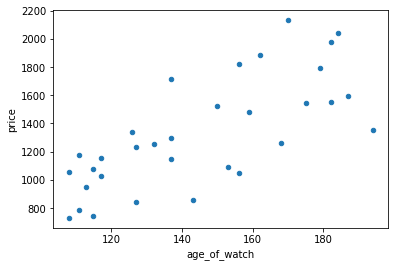

In [6]:
df.plot.scatter(y='price', x='age_of_watch')

In [7]:
wd()

NameError: name 'wd' is not defined